In [1]:
# imports
# Generic
import os
from pathlib import Path
import typing
import html

# Plotting
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Specify plotly renderer for vscode
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
import pandas as pd

# Transformer Stuff
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Utilities
from muutils.statcounter import StatCounter

# Our Code
from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.evaluation.eval_model import MazePath, load_model_with_configs, predict_maze_path
from maze_transformer.evaluation.pathdist import MazeEvalFunction, ArrMazeEvalFunction, MazeEvalFuncs, ArrMazeEvalFuncs

from scripts.create_dataset import create_dataset
from scripts.train_model import train_model

%load_ext autoreload
%autoreload 2

In [2]:
# -- Configuration --
# Set seed for reproducibility
seed = 42
_= torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DARK_MODE = True
if DARK_MODE:
    pio.templates.default = "plotly_dark"
    plt.style.use("dark_background")
    
# load model and configs - this should point towards a directory containing a run
dataset_path = Path("../data/maze/g3-n5-debugging/")
run_path = dataset_path / "g3-n5-debugging_tiny-v1_2023-03-05-17-29-11"
# run_path = Path("../data/maze/g5-n1000000")
# If you don't have any runs, you can use:
# try:
#     create_dataset(path_base="../data/maze/", n_mazes=5, grid_n=3, name="debugging")
# except FileExistsError:
#     print(f'{Path("../data/maze/debugging").as_posix()} already exists, skipping...')
#     pass
# train_model(basepath="../data/maze/g3-n5-debugging")

In [3]:
# We won't be training any models
torch.set_grad_enabled(False)

# Get latest model
model_path = list(sorted(run_path.glob('**/model.final.pt'), key=os.path.getmtime))
if len(model_path) == 0: # Get latest checkpoint instead
    model_path = list(sorted(run_path.glob('**/checkpoints/model.iter_*.pt'), key=os.path.getmtime))
model_path = model_path[-1].resolve()
print(model_path)
maze_path = dataset_path / 'maze_tokens.jsonl'

/media/home/alex/ongoing/maze-transformer/data/maze/g3-n5-debugging/g3-n5-debugging_tiny-v1_2023-03-05-17-29-11/model.final.pt


# plot example mazes

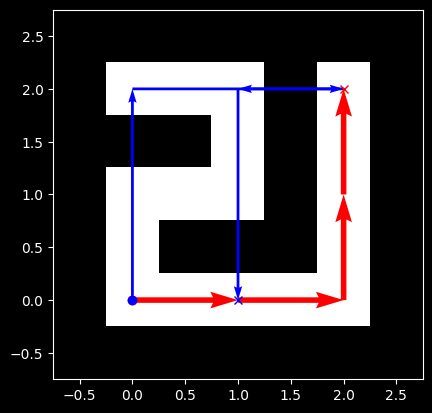

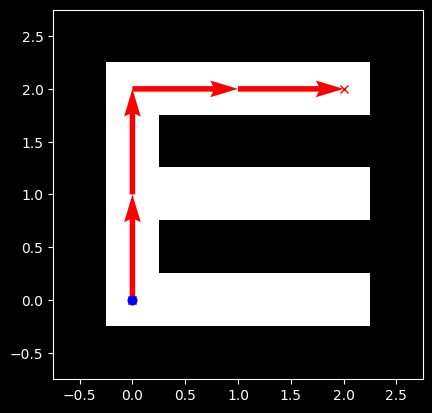

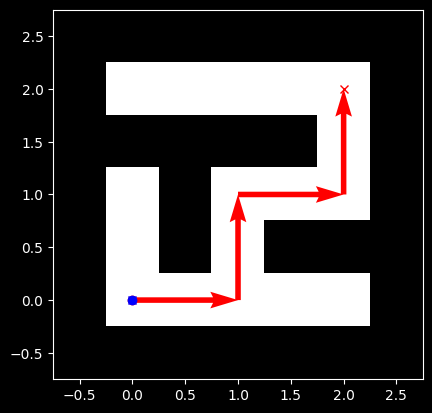

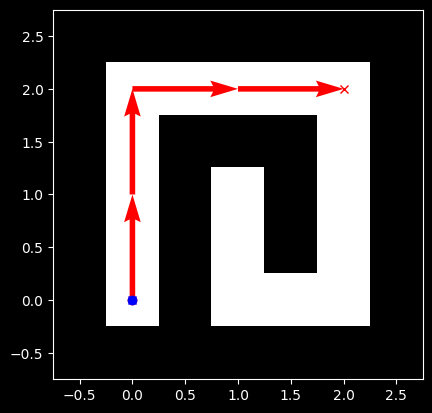

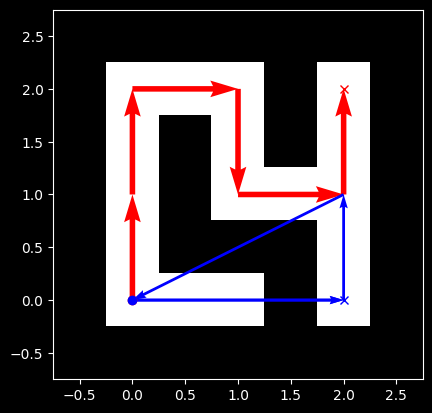

In [4]:
# setup consts
def testdata_plot_predicted_path(
		model_path: Path,
		maze_tokens_path: Path, 
		n_mazes: int = 10,
		n_tokens_pred: int = 8,
	):
	mazes_tokens: list[list[str]] = list()

	# load model and configs
	model, cfg = load_model_with_configs(model_path)
	
	# load maze test data
	mazes_tokens: list[list[str]] = [
 	   line.split() for line in maze_tokens_path.read_text().splitlines()
	]
	mazes_tokens = mazes_tokens[:n_mazes]

	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = [
		predict_maze_path(
			tokens = tokens,
			data_cfg = cfg.dataset_cfg,
			model = model,
		n_tokens_pred = n_tokens_pred,
		)
		for tokens in mazes_tokens
	]


	# plot
	for maze, path, path_pred in mazes_solved:
		plot_multi_paths(
			maze = maze,
			paths = [
				PathFormat(path, "true", color = "red", quiver_kwargs = {'width': 0.015}),
				PathFormat(path_pred, "predicted", color = "blue", quiver_kwargs = {}),
			],
		)

testdata_plot_predicted_path(model_path, maze_path)
# testdata_plot_predicted_path()

# run path dist eval

In [5]:
EvalFuncTuple = tuple[typing.Literal["arr", "list"], MazeEvalFunction|ArrMazeEvalFunction]

ALL_PATHDIST_FUNCS: dict[str, EvalFuncTuple] = {
	**{
		name: ("arr", func)
		for name, func in ArrMazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
	**{
		name: ("list", func)
		for name, func in MazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
}

print(ALL_PATHDIST_FUNCS)

{'num_connections_adjacent_lattice': ('arr', <staticmethod(<function ArrMazeEvalFuncs.num_connections_adjacent_lattice at 0x7f9104591cf0>)>), 'fraction_connections_adjacent_lattice': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent_lattice at 0x7f9104591d80>)>), 'num_connections_adjacent': ('arr', <staticmethod(<function ArrMazeEvalFuncs.num_connections_adjacent at 0x7f9104591e10>)>), 'fraction_connections_adjacent': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent at 0x7f9104591ea0>)>), 'node_overlap': ('list', <staticmethod(<function MazeEvalFuncs.node_overlap at 0x7f9104591c60>)>)}


In [7]:
from maze_transformer.evaluation.eval_model import ArrMazePath

import tqdm
def evaluate_model_pathdist_scores(
		model_path: Path,
		maze_tokens_path: Path,
		pathdist_functions: dict[str, EvalFuncTuple]|None = ALL_PATHDIST_FUNCS,
		n_tokens_pred: int = 8,
		n_mazes: int = 64,
		verbose: bool = False,
	) -> dict[str, StatCounter]:

	mazes_tokens: list[list[str]] = list()

	# load model and configs
	model, cfg = load_model_with_configs(model_path)

	# load maze test data
	mazes_tokens: list[list[str]] = [
 	   line.split() for line in maze_tokens_path.read_text().splitlines()
	]

	mazes_tokens_initial = mazes_tokens
	mazes_tokens_after = []
	with open(maze_tokens_path, "r") as f:
		for idx, line in enumerate(f):
			mazes_tokens_after.append(line.split())
			if idx >= n_mazes:
				break
	assert all([x==y for x,y in zip(mazes_tokens_initial, mazes_tokens_after)])
	print('passed check')

	# Predict paths
	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = list()
	for tokens in mazes_tokens:
		#TODO Batch the maze generation - is padding done by default for the tokenizer in HkTf?
		maze, p_true, p_pred = predict_maze_path(
			tokens = tokens,
			data_cfg = cfg.dataset_cfg,
			model = model,
			n_tokens_pred = n_tokens_pred,
			verbose = verbose,
		)

		mazes_solved.append((maze, p_true, p_pred))

		if verbose:
			print(f"{p_true = }")
			print(f"{p_pred = }")

	# convert paths
	mazes_solved_arrpath: list[tuple[LatticeMaze, ArrMazePath, ArrMazePath]] = [
		(maze, np.array(p_true), np.array(p_pred))
		for maze, p_true, p_pred in mazes_solved
	]

	# evaluate
	pathdist_scores: dict[str, StatCounter] = dict()
	for name, (pathdist_type, pathdist_func) in pathdist_functions.items():
		if pathdist_type == "list":			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved
			)
		elif pathdist_type == "arr":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved_arrpath
			)
		else:
			raise ValueError(f"Invalid pathdist_type: {pathdist_type}")

	return pathdist_scores

evaluate_model_pathdist_scores(model_path, maze_path)

passed check


{'num_connections_adjacent_lattice': {
   "StatCounter": {
     "0.0": 3,
     "1": 1,
     "2": 1
   },
   "summary": {
     "total_items": 5,
     "n_keys": 3,
     "mode": 0.0,
     "mean": 0.6,
     "std": 0.7999999999999999,
     "min": 0.0,
     "q1": 0.0,
     "median": 0.0,
     "q3": 1.0,
     "max": 2
   }
 },
 'fraction_connections_adjacent_lattice': {
   "StatCounter": {
     "0.0": 3,
     "0.2": 1,
     "0.2857142857142857": 1
   },
   "summary": {
     "total_items": 5,
     "n_keys": 3,
     "mode": 0.0,
     "mean": 0.09714285714285714,
     "std": 0.12202375145178641,
     "min": 0.0,
     "q1": 0.0,
     "median": 0.0,
     "q3": 0.2,
     "max": 0.2857142857142857
   }
 },
 'num_connections_adjacent': {
   "StatCounter": {
     "0.0": 3,
     "1": 2
   },
   "summary": {
     "total_items": 5,
     "n_keys": 2,
     "mode": 0.0,
     "mean": 0.4,
     "std": 0.48989794855663565,
     "min": 0.0,
     "q1": 0.0,
     "median": 0.0,
     "q3": 1.0,
     "max": 1
   }


In [8]:
def evaluate_pathdist_scores_checkpoints(
		run_path: Path, # Path to run, not model.final.pt or checkpoints
		maze_tokens_path: Path,
		checkpoint_idxs: list[int]|None = None,
		pathdist_functions: dict[str, EvalFuncTuple]|None = ALL_PATHDIST_FUNCS,
		skip_every_nth: int = 1,
		n_tokens_pred: int = 8,
		n_mazes: int = 10,
		verbose: bool = False,
	) -> dict[str, dict[int, StatCounter]]:

	model_checkpoints: list[tuple[int,Path]]
	assert run_path.is_dir(), f"Model path {run_path} is not a directory (expect run directory, not model files)"
 
	if checkpoint_idxs is not None:
		model_checkpoints = list()
		for idx in checkpoint_idxs:
			mdl_path: Path = Path(run_path) / f"checkpoints/model.iter_{idx}.pt"
			if not mdl_path.exists():
				raise ValueError(f"Checkpoint file {mdl_path} does not exist")
			model_checkpoints.append((idx, mdl_path))
	else:
		model_checkpoints = [
			(int(mdl_path.stem.split("_")[-1].split(".")[0]), mdl_path)
			for mdl_path in sorted(Path(run_path).glob("checkpoints/model.iter_*.pt"))
		]
	
	print(f"Found {len(model_checkpoints)} checkpoints:\n\t{model_checkpoints = }")

	pathdist_scores_idx: dict[int, dict[str, StatCounter]] = dict()

	for idx, mdl_path in model_checkpoints[::skip_every_nth]:

		print(f"# Evaluating checkpoint {idx} at {mdl_path}")
		pathdist_scores_idx[idx] = evaluate_model_pathdist_scores(
			model_path = mdl_path,
			pathdist_functions = pathdist_functions,
			n_tokens_pred = n_tokens_pred,
			maze_tokens_path = maze_tokens_path,
			n_mazes = n_mazes,
			verbose = verbose,
		)

	return {
		name: {
			idx: scores[name]
			for idx, scores in pathdist_scores_idx.items()
		}
		for name in pathdist_scores_idx.values().__iter__().__next__() # get first dict's values
	}

data = evaluate_pathdist_scores_checkpoints(
	run_path = run_path,
	maze_tokens_path = maze_path,
	n_mazes = 1000,
	# skip_every_nth=10,
	checkpoint_idxs=[0],
	# verbose = True,
)

Found 1 checkpoints:
	model_checkpoints = [(0, PosixPath('../data/maze/g3-n5-debugging/g3-n5-debugging_tiny-v1_2023-03-05-17-29-11/checkpoints/model.iter_0.pt'))]
# Evaluating checkpoint 0 at ../data/maze/g3-n5-debugging/g3-n5-debugging_tiny-v1_2023-03-05-17-29-11/checkpoints/model.iter_0.pt
passed check


In [9]:
def plot_pathdist_scores(
		data: dict[str, dict[int, StatCounter]],
		colors: dict[str, str]|None = None,
		percentile_bounds: tuple[float, float] = (0.4, 0.6),
	):

	if colors is None:
		colors = {
			func_name: f"C{i}"
			for i, func_name in enumerate(data.keys())
		}

	fig, ax = plt.subplots(len(data), 1, figsize = (8, 4 * len(data)))
	fig.subplots_adjust(hspace = 0.5)
		
	for i, (name, scores_idxed) in enumerate(data.items()):
		x = list(scores_idxed.keys())
		y = [
			scores_idxed[idx].median()
			for idx in x
		]
		ax[i].plot(x, y, label=name, color=colors[name])
		# plot shaded error bars
		y_ub = [
			scores_idxed[idx].percentile(percentile_bounds[1])
			for idx in x
		]
		y_lb = [
			scores_idxed[idx].percentile(percentile_bounds[0])
			for idx in x
		]
		ax[i].fill_between(
			x, y_lb, y_ub,
	    	alpha=0.5, 
			edgecolor=colors[name], facecolor=colors[name],
		)

		ax[i].set_title(f"{name}, {percentile_bounds = }")
		ax[i].set_xlabel("Checkpoint")
		ax[i].set_ylabel("score")

	plt.show()

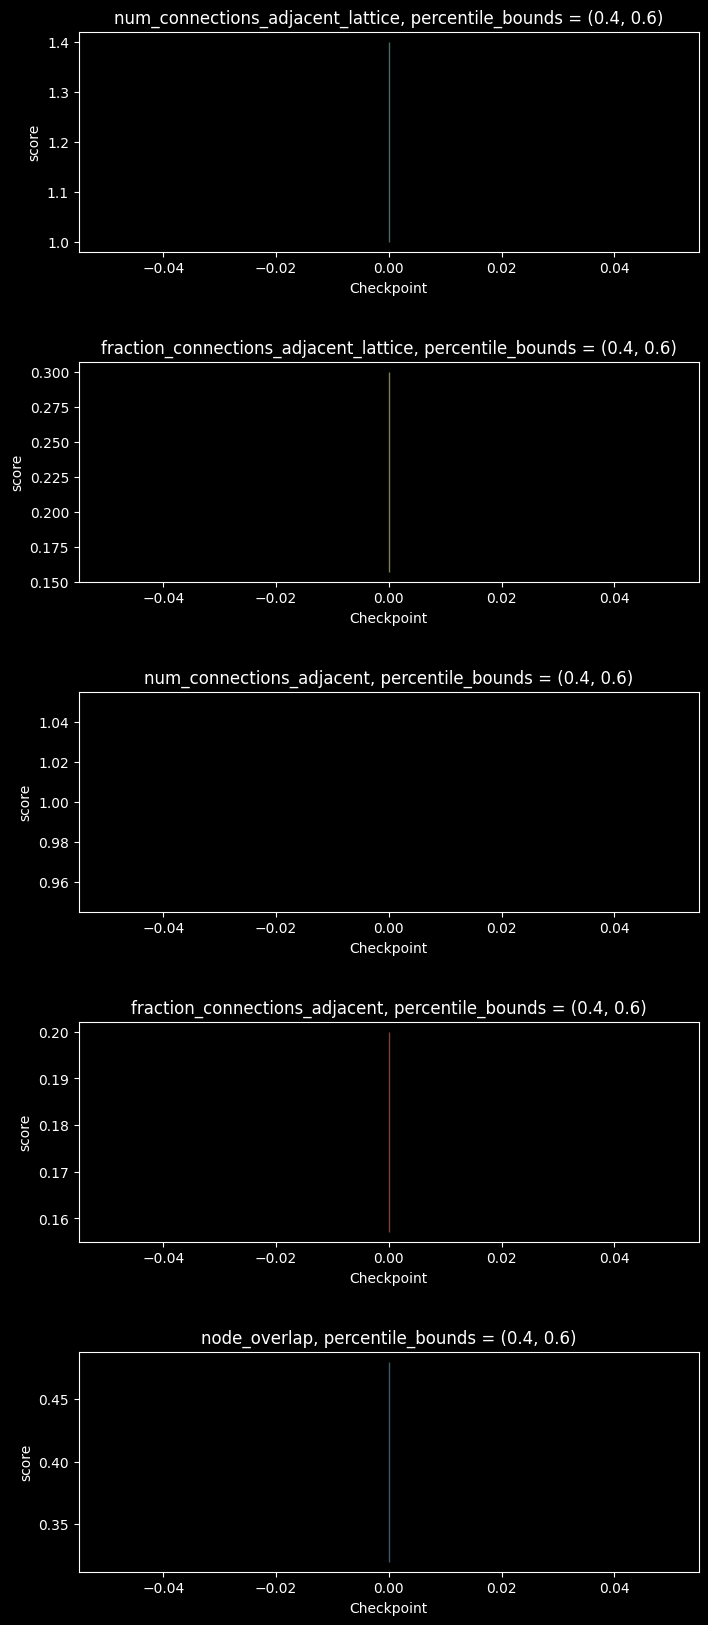

In [10]:
plot_pathdist_scores(data)